In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import random
from collections import Counter

### Data processing

In [4]:
# 训练集的数据增强与预处理
train_transform = transforms.Compose([
    transforms.Resize(240),                  # 将短边调整到240
    transforms.CenterCrop(224),              # 中心裁剪为224×224
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 颜色抖动
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 归一化
])

# 验证集与测试集的预处理
test_transform = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 加载数据集
train_data = ImageFolder(root=os.path.join(os.getcwd() + '/datasets/train'), transform=train_transform)
val_data = ImageFolder(root=os.path.join(os.getcwd() + '/datasets/val'), transform=test_transform)


In [5]:
# from collections import Counter
# labels = [label for _, label in val_data.samples]
# print(f"Label Counts: {Counter(labels)}")

total_indices_train = list(range(len(train_data)))
random.shuffle(total_indices_train)
selected_indices_train = total_indices_train[:5000]

total_indices_val = list(range(len(val_data)))
random.shuffle(total_indices_val)
selected_indices_val = total_indices_val[:500]

# 训练集只取5000张, 验证集取500张
train_subset = Subset(train_data, selected_indices_train)
val_subset = Subset(val_data, selected_indices_val) 

subset_labels = [train_data.targets[i] for i in selected_indices_train]
print(f"Subset Label Counts: {Counter(subset_labels)}")

# 数据加载器
# train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


Subset Label Counts: Counter({1: 2519, 0: 2481})


### Network

In [7]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features  # 获取全连接层的输入特征数
model.fc = nn.Linear(num_features, 1)  # 二分类：1个输出节点

### Train

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [9]:
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # 更稳定的损失函数（无需手动添加 Sigmoid）
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []

num_epochs = 20

def validate(model, val_loader):
    """在验证集上评估模型性能"""
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    val_loss = 0.0  # 记录验证集上的损失

    # 使用 no_grad 避免计算梯度，提高评估速度
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)

            # 前向传播
            outputs = model(inputs)

            # 计算损失
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 使用 Sigmoid 函数将输出转换为 [0, 1] 之间的概率
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            # 计算准确率
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 打印验证损失和准确率
    avg_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 返回平均损失（用于 Early Stopping 或学习率调度）
    return avg_loss

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        初始化 EarlyStopping
        :param patience: 等待多少个 epoch 后停止训练
        :param min_delta: 损失改善的最小值
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 初始化 EarlyStopping
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0


    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'Loss': running_loss / (pbar.n + 1)})  # 进度条
            pbar.update(1)


    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # 保存每个 epoch 的损失
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

    # 在验证集上评估模型性能
    val_loss = validate(model, val_loader)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break  # 结束训练

print("训练完成！")


Epoch 1/20:  76%|███████▌  | 474/625 [03:18<01:03,  2.39batch/s, Loss=0.285]


KeyboardInterrupt: 

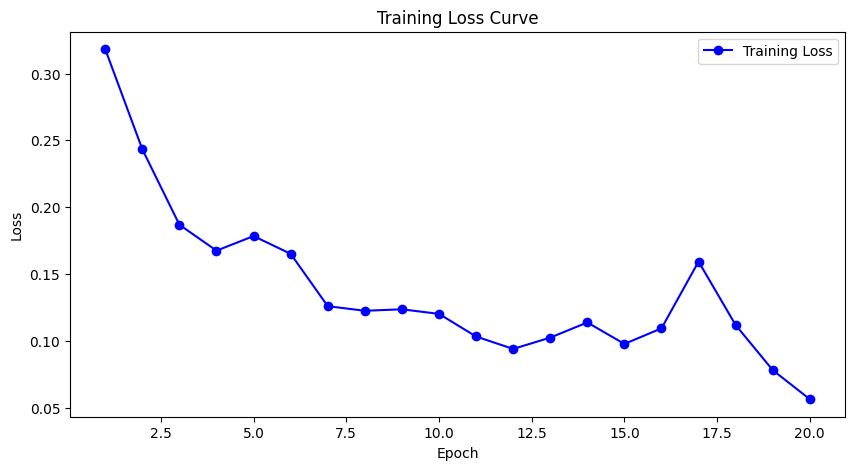

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


### Validation

In [70]:
model.eval()  # 设置模型为评估模式
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

print(f'验证准确率：{100 * correct / total:.2f}%')


验证准确率：93.20%


### Test

In [73]:
model.eval()
def predict_image(image_path, model):
    """对单张图片进行预测并返回标签"""
    img = Image.open(image_path).convert('RGB')  # 确保图片是RGB格式
    img = test_transform(img).unsqueeze(0).to(device)  # 预处理图片

    with torch.no_grad():
        output = model(img)
        prediction = torch.sigmoid(output).item()

    # 将预测结果转换为0或1：0表示Cat，1表示Dog
    return 1 if prediction >= 0.5 else 0

test_folder = os.path.join(os.getcwd() + '/datasets/test')
# 遍历测试文件夹并收集预测结果
results = []  # 存储 (文件名, 预测结果) 的列表 
for img_file in os.listdir(test_folder):
    img_path = os.path.join(test_folder, img_file)
    if img_file.endswith(('.jpg', '.png', '.jpeg')):  # 过滤图片格式
        label = predict_image(img_path, model)
        img_id, _ = os.path.splitext(img_file)  # 去掉扩展名
        results.append([img_id, label])

# 将结果保存为 CSV 文件
df = pd.DataFrame(results, columns=['id', 'label'])
df['id'] = df['id'].astype(int)  # 转换为整数
df = df.sort_values(by='id')
df.to_csv(os.path.join(os.getcwd() +'/prediction_results.csv'), index=False)

print("预测结果已保存为 prediction_results.csv")



预测结果已保存为 prediction_results.csv
